# Compute escape lifetimes from OPESF runs

## Import required libraries

In [1]:
import os
import numpy as np
import seaborn as sns
import scipy.spatial.distance
import scipy.ndimage.filters
from scipy.optimize import curve_fit
from scipy.stats import gamma as gamma_sci
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as fm
from matplotlib.pyplot import cm

# Edit the font, font size, and axes width
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['font.family'] = 'Sans'
#mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.linewidth'] = 2

%matplotlib inline

## define useful functions for calculating acceleration factor, cdf fitting, plotting and writing cdfs, etc. 

In [2]:

# Function to calculate the TCDF with constants rate
def func(x, a):
    return 1 - np.exp(-a * x)

# compute ecdf
def get_ecdf(time_list, min_time, max_time, n_bins, n_traj):
    time_domain = np.logspace(np.log10(min_time), np.log10(max_time), n_bins)
    N = n_traj
    a, b = np.histogram(time_list, time_domain)
    ECDF = np.cumsum(a)/N
    if len(time_domain[:-1]) == len(ECDF):
        return time_domain[:-1], ECDF
    else:
        return "error"


def compute_cdfs(time_list, n_traj):
    min_t = np.min(time_list)/100
    if len(time_list) != n_traj:
        max_t = np.max(time_list)
    else:
        max_t = np.max(time_list)*100
    nbins = 500
    x, y = get_ecdf(time_list, min_t, max_t, nbins, n_traj)
    test_mean = np.sum(time_list)/n_traj
    test_sigma = np.std(time_list, ddof=1)
    test_m = np.median(time_list)
    means = test_mean
    medians = test_m
    uncertainty = test_sigma/np.sqrt(len(time_list))
    stdvs = test_sigma
    mean_sigma_ratio = test_mean/test_sigma
    log2_median_ratio = np.log(2)*test_mean/test_m
    guess = 1.0/test_mean
    # get tau from cdf fitting
    pars, cov = curve_fit(f=func, xdata=x, ydata=y, p0=[guess], maxfev=1000000)
    stdevs = np.sqrt(np.diag(cov))
    f_stdvs = stdevs[0]
    tau = 1/pars[0]
    tau_mean_ratio = (tau / test_mean)
    tcdf_x = np.logspace(np.log10(min_t), np.log10(10e3), nbins)
    # get TCDF for same time_domain using fitted tau
    tcdf = gamma_sci.cdf(tcdf_x, 1, scale=tau)
    cdfs = [x, y, tcdf, tcdf_x]
    data = [tau, stdvs, f_stdvs, means, medians,
            uncertainty, mean_sigma_ratio, log2_median_ratio, tau_mean_ratio]
    return cdfs, data


def plot_cdfs(x, y,tx,tcdf, rid, force, model_name, out_dir):

    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.step(x, y, c='k', label=F'ECDF: F={np.abs(float(force))} {model_name}')
    ax.plot(tx, tcdf, label=F'TCDF: F={np.abs(float(force))} {model_name}', c='r')
    ax.set_xscale('log')
    ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
    ax.set_xlim(min(tx), max(tx))
    ax.tick_params(axis='both', labelsize=14, width=2)
    plt.legend(fontsize=14, loc='upper left', frameon=False)
    fig.tight_layout()
    out_path = os.path.join(out_dir,f'F{force}_{model_name}{rid}.png')
    plt.savefig(out_path)
    plt.close()
    return 1

def do_KS2test(time_list, tau):
    size = np.int64(len(time_list) * 1e6)
    rvs1 = gamma_sci.rvs(1, scale=tau, size=size)  # loc=min(time_list))
    ks_stat, p = stats.ks_2samp(rvs1, time_list)
    return ks_stat, p


def write_cdfs(x, y, tx, tcdf, rid, force, model_name, out_dir):
    out_path = os.path.join(out_dir,f'F{force}_{model_name}{rid}.dat')
    out_file = open(out_path, 'w')
    out_file.write("#scaled time \t ecdf \n")
    for i in range(len(x)):
        print(F"{x[i]:>10} \t {y[i]:>10}", file=out_file)
    out_file.close()
    out_path = os.path.join(out_dir,f'F{force}_{model_name}{rid}t.dat')
    out_filet = open(out_path, 'w')
    out_filet.write("#scaled time \t tcdf \n")
    for i in range(len(tx)):
        print(F"{tx[i]:>10} \t {tcdf[i]:>10}", file=out_filet)
    out_filet.close()
        
    return 1
    
    
def plot_life_time_err(force_list, tau_list, model_name, out_dir, id, error, l_loc='best'):
    force_list = np.array(force_list)*-1
    tau_list = np.array(tau_list)
    fig, ax = plt.subplots(figsize=(7, 4))
    tot_n_force = len(force_list)
    
    lab = F"{model_name}"
    if model_name=='holo':
        lcolor='b'
    else:
        lcolor='r'
    ax.plot(force_list, tau_list, c=lcolor,marker='o',label=f"{model_name}", linestyle='', mec='k')
    ax.errorbar(force_list, tau_list, error, c=lcolor, linestyle='', capsize=3)
    ax.tick_params(axis='both', labelsize=16, width=2)
    ax.legend(fontsize=12, loc=l_loc)
    ax.set_ylabel(r"$lifetime\ (s)$", fontsize=16)
    plt.xlabel(r"$Force\ (pN)$", fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=.92)
    out_path = os.path.join(out_dir, f'{model_name}{id}_ratesvsForce_err.pdf')
    plt.savefig(out_path, format='pdf')
    plt.show()
    plt.close()
    return out_path


def calc_acceleration_column(bias, kT, timestep, barrier):
    beta = 1/kT
    bias_shift = bias + barrier 
    acceleration_col = np.divide(np.cumsum(np.exp(beta*bias_shift)), np.arange(1,len(bias)+1))
    return acceleration_col


def calc_acceleration(bias, kT, timestep, barrier):
    tot_time = (len(bias)-1)*timestep
    beta = 1/kT
    bias_shift = bias + barrier
    integral = np.sum(np.exp(beta*bias_shift)*timestep)
    alpha = integral/tot_time
    return alpha

## Set colvar,bias data location and read data in in next cell

In [3]:
workdir = os.path.join('/media','wpc252','Expansion1','greene_scratch','projects','project-4','actin-vinculin-prod','actin_apoVinc_RATE_pullProj_prod_pn')
figure_dir = 'test_figs'
data_dir = 'test_out'
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
workdir

'/media/wpc252/Expansion1/greene_scratch/projects/project-4/actin-vinculin-prod/actin_apoVinc_RATE_pullProj_prod_pn'

In [4]:
force_vs_last_times = {}
cv_bias_data = {}

for i in np.linspace(-40.0,40.0,9):
    key = str(round(i,3))
    cv_bias_data[key]=[]

# output file containing time,colvars and bias
file_template = "_FORCE/DIR/DIR_rate_pullVt.cvs_bias.dat" 


for key in cv_bias_data:
    file_name = file_template.replace('FORCE', key)
    last_times = []
    # 30 runs for 0 force labeled 26 to 55
    # 20 runs per pulling force labeled 26 to 45
    if key == '0.0':
        max_runs = 55
    else:
        max_runs = 45
    for r in range(26,max_runs + 1):
        final_name = file_name.replace('DIR',str(r))
        dist = np.genfromtxt(workdir+final_name, comments='#', dtype=float)
        last_times.append(dist[:,0:5][-1])
        cv_bias_data[key].append(dist)
        
    force_vs_last_times[key] = np.array(last_times)

## check shape of array for each force, should be n_runs by n_colvars + 1 (bias)

In [5]:
for f,runs in force_vs_last_times.items():
    print(f, runs.shape)

-40.0 (20, 5)
-30.0 (20, 5)
-20.0 (20, 5)
-10.0 (20, 5)
0.0 (30, 5)
10.0 (20, 5)
20.0 (20, 5)
30.0 (20, 5)
40.0 (20, 5)


## plot average unscaled last times in ns for each force

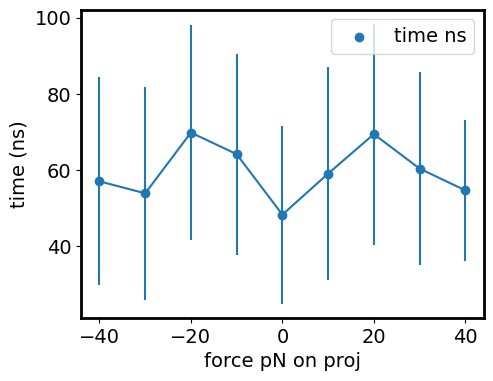

In [7]:
forces_pN = []
mean_ns_times = []
std_ns_times = []
mean_escape_times = {}
for key in force_vs_last_times:
    last_vals = force_vs_last_times[key]
    last_times = last_vals[:,0]*1e-6
    escape_times = last_times 
    mean_escape_times[key]=(np.mean(escape_times),np.std(escape_times),len(escape_times))

for k,v in mean_escape_times.items():
    forces_pN.append(float(k))
    mean_ns_times.append(v[0])
    std_ns_times.append(v[1])

fig, ax1 = plt.subplots(1, 1, figsize=(7,4))   
ax1.scatter(np.array(forces_pN)*-1, mean_ns_times, label='time ns') #forces are flipped to match convention
ax1.errorbar(np.array(forces_pN)*-1, mean_ns_times, std_ns_times)
ax1.set_xlabel('force pN on proj')
ax1.set_ylabel('time (ns)')
plt.legend()
plt.subplots_adjust(right=0.7)
plt.show()


## calculate acceleration factor ( scaling factor) for each run of ech force

In [8]:
barrier=10 # kcal/mol
kbT = 0.596161 # kcal/mol
timestep = 2000 # cv and bias written out every 1000 (1000 steps, 2 fs timestep) Femtoseconds
time_unit = 1e-15 
alpha_runs = {}
for key in cv_bias_data:
    alphas = []
    runs = cv_bias_data[key]
    for run in runs:
        bias=run[:,4]
        alpha = calc_acceleration(bias, kbT, timestep, barrier)
        alphas.append(alpha)
    alpha_runs[key]=alphas

## scale escape times by acceleration factor

In [9]:
scaled_times_force = {}
for key in force_vs_last_times:
    last_times = force_vs_last_times[key][:,0]
    last_alpha = alpha_runs[key]
    scaled_times = []
    for t,a in zip(last_times, last_alpha):
        scaled_time=t*a*time_unit
        # print(key,t,a,scaled_time)
        scaled_times.append(scaled_time)
    scaled_times_force[key]=scaled_times

## Obtain tau for each force
### Perform fitting of the CDF of scaled escape times of each force to CDF of an exponential distribution.
### Plot,save, and write CDF fits to ouputdirectories
### Perform KS2 goodnes of fit test
### Perform error calculation by bootstrap

In [10]:
tau_force = []
scaled_stats = {}
forces_pN = []
boot_tau = []
error_bars = []
p_values = []
f_transitions = []
for k in scaled_times_force:
    scaled_times = scaled_times_force[k]
    unscaled_last_times = force_vs_last_times[k][:,0]*1e-6 # ns 
    events = unscaled_last_times < 100 # ns
    transitions = np.array(scaled_times)[events]
    if k == '0.0':
        ntraj = 30
    else:
        ntraj = 20
    time_list = transitions
    forces_pN.append(float(k))
    cdfs, data_t = compute_cdfs(time_list,ntraj)
    time_domain = cdfs[0]
    ecdf = cdfs[1]
    tcdf = cdfs[2]
    tx = cdfs[3]
    tau = data_t[0]
    plot_cdfs(x=time_domain, y=ecdf, tx=tx, tcdf=tcdf, rid='test', force=k, model_name='apo', out_dir=figure_dir)
    write_cdfs(x=time_domain, y=ecdf, tx=tx, tcdf=tcdf, rid='test', force=k, model_name='apo', out_dir=data_dir)
    s, p = do_KS2test(time_list, tau)
    scaled_stats[k]=[tau,p]
    tau_force.append(tau)
    f_transitions.append(len(time_list))
    print("Force: ", k, len(time_list))
    print(tau, p)
    p_values.append(p)
    # bootstrap 
    tau_estimates = []
    for b in range(200):
        boot = np.random.choice(time_list, size=len(scaled_times), replace=True)
        cdfs, data = compute_cdfs(boot,len(boot))
        boot_mean = data[0]
        tau_estimates.append(boot_mean)
    # end of bootstrap
    error=np.std(tau_estimates)
    bootstrap_mean= np.mean(tau_estimates)
    boot_tau.append(bootstrap_mean)
    error_bars.append(error)

Force:  -40.0 19
0.1303965502591154 0.8630597424629672
Force:  -30.0 18
0.13666319860911533 0.3654038214918375
Force:  -20.0 15
0.19045928143184418 0.24755917373814496
Force:  -10.0 17
0.14615061671499552 0.41452444123346266
Force:  0.0 29
0.1314447119562131 0.50737445343168
Force:  10.0 19
0.14696294689374884 0.9162585666945111
Force:  20.0 17
0.22992333680260538 0.3179275290910435
Force:  30.0 18
0.1295837291961931 0.8531453157795814
Force:  40.0 18
0.11181137011803254 0.5826745220587329


## Plot lifetimes, rates vs force, plot error bars and write out  force, tau, and error

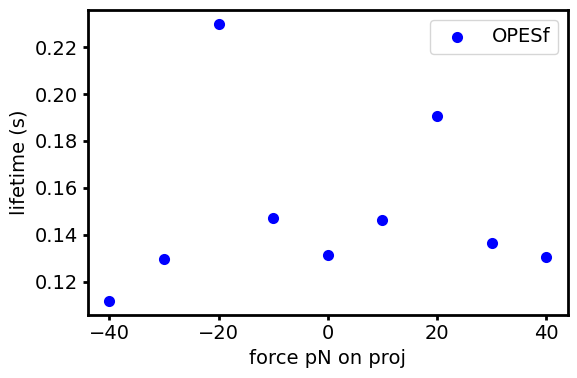

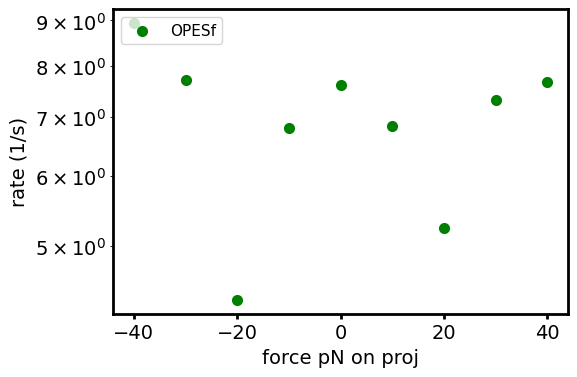

In [11]:
forces_pN = np.array([float(k) for k in scaled_times_force])
taus = np.array(tau_force)
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(forces_pN*-1, taus, c='b', label="OPESf", lw=2)
ax.tick_params(axis='both', labelsize=14, width=2)
ax.set_xlabel('force pN on proj')
ax.set_ylabel('lifetime (s)')
plt.legend(fontsize=14, loc='best')
#plt.yscale('log')
fig.tight_layout()
out_path =f'{figure_dir}/opesf_apo_lifetime_pullproj_test.png'
plt.savefig(out_path)
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(forces_pN*-1, 1/np.array(taus), c='g', label="OPESf", lw=2)
ax.tick_params(axis='both', labelsize=14, width=2)
ax.set_xlabel('force pN on proj')
ax.set_ylabel('rate (1/s)')
plt.legend(fontsize=11, loc='upper left')
out_path =f'{figure_dir}/opesf_apo_rate_pullproj_test.png'
plt.yscale('log')
fig.tight_layout()
plt.savefig(out_path)
plt.show()

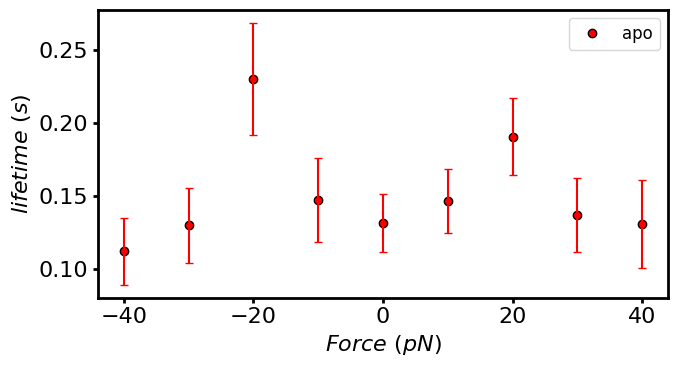

'test_figs/apoescaped_test_ratesvsForce_err.pdf'

In [12]:
plot_life_time_err(forces_pN, taus, 'apo', figure_dir, 'escaped_test', error_bars)

In [13]:
rate_data_err_file = open(F'{data_dir}/f_lifetimes_force_err_proj_test.dat', 'w')
rate_data_err_file.write("#Force  taus  error jumps\n")
for i in range(len(forces_pN)):
    rate_data_err_file.write(F"{forces_pN[i]} {taus[i]} {error_bars[i]} {f_transitions[i]}\n")
rate_data_err_file.close()

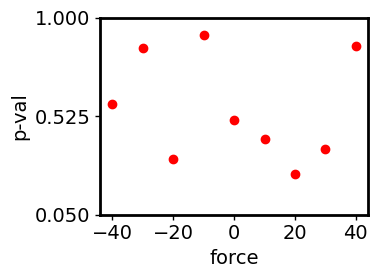

In [14]:
pvals = []
for item in scaled_stats.items():
    p = item[1][1]
    pvals.append(p)
    
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.scatter(forces_pN*-1, pvals, c='r', label="OPESf")
ax.set_ylabel('p-val')
ax.set_xlabel('force')
ax.tick_params(axis='both', labelsize=14, width=1)
ax.set_yticks([i for i in np.linspace(0.05,1,3)])
ax.set_xticks([i for i in np.linspace(-40.0,40.0,5)])
out_path =f'{figure_dir}/opesf_apo_pvals.png'
fig.tight_layout()
plt.savefig(out_path)
plt.show()
  